# Customer Segmentation / Clustering

Here, we are using the K-means clustering algorithm to determine the optimal clustering of users into separate groups.

K-Means: Our approach uses the Elbow method to determine the optimal number of clusters and final model gives a DBI of 1.308 for k = 5 and 0.956 for k = 10. We prefer k = 5 according to the elbow method to avoid overfitting and enhanced model interpretability.

DBSCAN: Results in 14 clusters for an epsilon value of 0.5 for DBI = 1.307. For epsilon = 0.3, it results in 5 clusters with a DBI of 1.134.

In [78]:
import pandas as pd
from datetime import datetime

customers = pd.read_csv('drive/MyDrive/Zeotap Assignment/Data/Customers.csv')
transactions = pd.read_csv('drive/MyDrive/Zeotap Assignment/Data/Transactions.csv')
products = pd.read_csv('drive/MyDrive/Zeotap Assignment/Data/Products.csv')

In [79]:
transactions = pd.merge(
    transactions,
    products[['ProductID', 'ProductName', 'Category', 'Price']],
    on='ProductID',
    how='left',
    suffixes=('_transaction', '_product')
)
transactions = transactions.drop(columns=['Price_transaction'])
transactions = transactions.rename(columns={'Price_product': 'Price'})

customer_features = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],
    'Quantity': ['sum', 'mean'],
    'Price': 'mean',
    'Category': lambda x: x.mode()[0],
    'TransactionDate': lambda x: (datetime.now() - pd.to_datetime(x.max())).days
}).reset_index()


In [80]:
from sklearn.preprocessing import MinMaxScaler

customer_features.columns = ['CustomerID', 'TotalValue_sum', 'TotalValue_mean', 'Quantity_sum', 'Quantity_mean', 'Price_mean', 'FavoriteCategory', 'DaysSinceLastTransaction']
customer_data = pd.merge(customer_features, customers, on='CustomerID', how='left')
customer_data = customer_data.drop(columns=['CustomerName', 'SignupDate'])
customer_data = pd.get_dummies(customer_data, columns=['Region', 'FavoriteCategory'])

scaler = MinMaxScaler()
numerical_features = ['TotalValue_sum', 'TotalValue_mean', 'Quantity_sum', 'Quantity_mean', 'Price_mean', 'DaysSinceLastTransaction']
customer_data[numerical_features] = scaler.fit_transform(customer_data[numerical_features])

print(customer_data.head())

  CustomerID  TotalValue_sum  TotalValue_mean  Quantity_sum  Quantity_mean  \
0      C0001        0.308942         0.474336      0.354839       0.466667   
1      C0002        0.168095         0.308940      0.290323       0.500000   
2      C0003        0.249541         0.482751      0.419355       0.833333   
3      C0004        0.497806         0.473092      0.709677       0.625000   
4      C0005        0.184287         0.480120      0.193548       0.444444   

   Price_mean  DaysSinceLastTransaction  Region_Asia  Region_Europe  \
0    0.519414                  0.152778        False          False   
1    0.367384                  0.069444         True          False   
2    0.338446                  0.347222        False          False   
3    0.436848                  0.013889        False          False   
4    0.548476                  0.150000         True          False   

   Region_North America  Region_South America  FavoriteCategory_Books  \
0                 False        

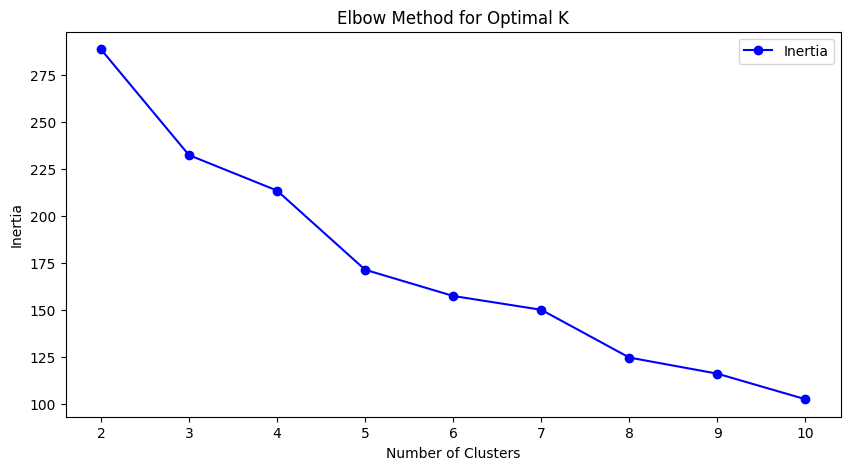

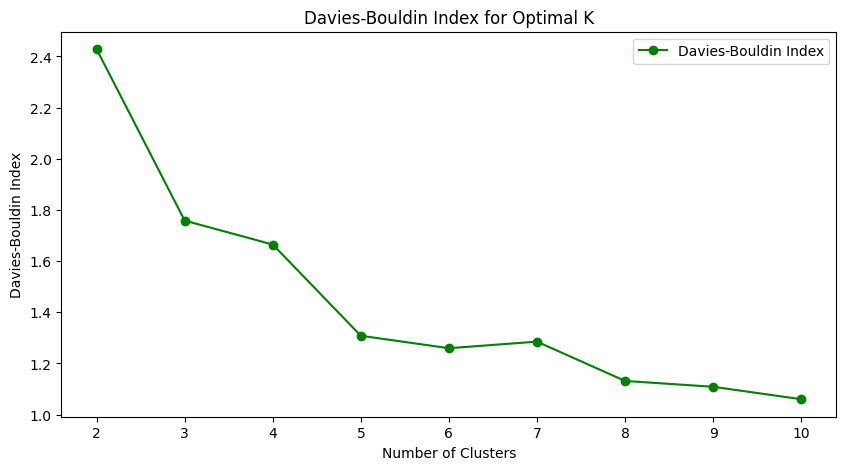

In [81]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

inertia = []
db_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data.drop(columns=['CustomerID']))
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(customer_data.drop(columns=['CustomerID']), kmeans.labels_))

plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bo-', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(K, db_scores, 'go-', label='Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal K')
plt.legend()
plt.show()

In [82]:
optimal_k = 5

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data.drop(columns=['CustomerID']))

X = customer_data.drop(columns=['CustomerID', 'Cluster'])
db_index = davies_bouldin_score(X, customer_data['Cluster'])
silhouette_avg = silhouette_score(X, customer_data['Cluster'])
ch_score = calinski_harabasz_score(X, customer_data['Cluster'])

# Print the results
print(f"Davies-Bouldin Index for {optimal_k} clusters: {db_index}")
print(f"Silhouette Score for {optimal_k} clusters: {silhouette_avg}")
print(f"Calinski-Harabasz Index for {optimal_k} clusters: {ch_score}")

Davies-Bouldin Index for 5 clusters: 1.308293241537378
Silhouette Score for 5 clusters: 0.30990063490812336
Calinski-Harabasz Index for 5 clusters: 46.48634126336333


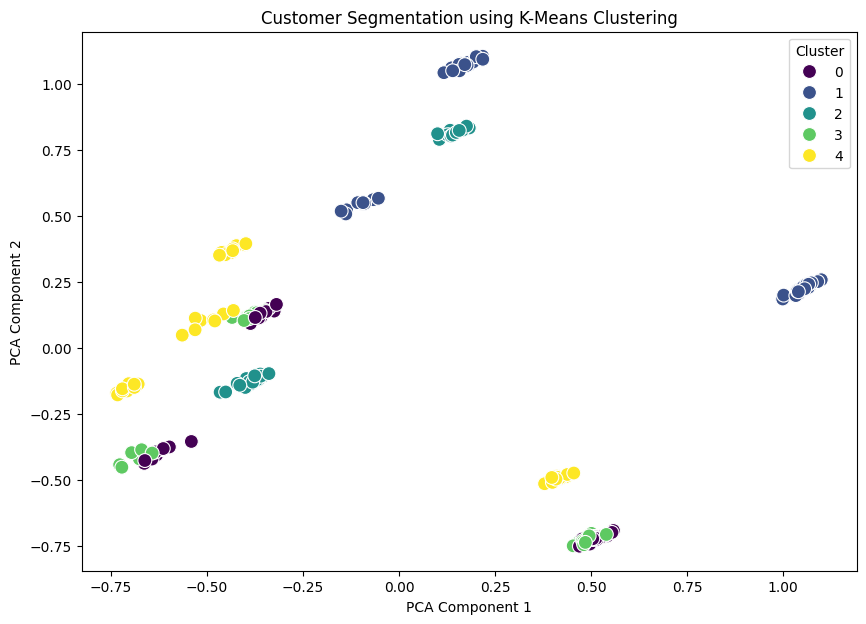

In [83]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_data.drop(columns=['CustomerID', 'Cluster']))

customer_data['PCA1'] = pca_result[:, 0]
customer_data['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='viridis', s=100)
plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

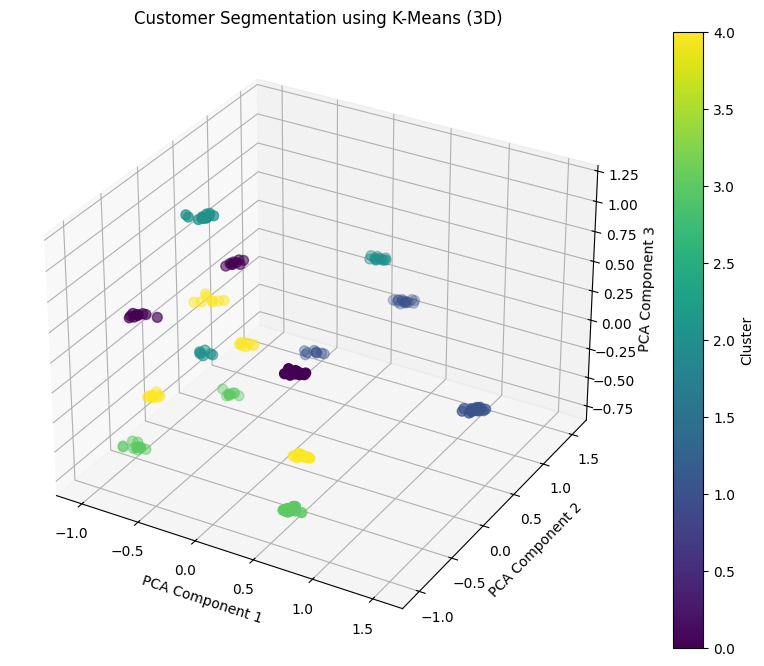

In [84]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

pca = PCA(n_components=3)
pca_result = pca.fit_transform(customer_data.drop(columns=['CustomerID', 'Cluster']))

customer_data['PCA1'] = pca_result[:, 0]
customer_data['PCA2'] = pca_result[:, 1]
customer_data['PCA3'] = pca_result[:, 2]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    customer_data['PCA1'],
    customer_data['PCA2'],
    customer_data['PCA3'],
    c=customer_data['Cluster'],
    cmap='viridis',
    s=50
)

plt.colorbar(scatter, ax=ax, label='Cluster')
ax.set_title('Customer Segmentation using K-Means (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.show()

In [85]:
# Save the clustered data
customer_data.to_csv('Clustered_Customers.csv', index=False)

In [86]:
#Experimenting with DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

dbscan = DBSCAN(eps=0.45, min_samples=5)
customer_data['Cluster'] = dbscan.fit_predict(customer_data.drop(columns=['CustomerID']))

db_index = davies_bouldin_score(customer_data.drop(columns=['CustomerID', 'Cluster']), customer_data['Cluster'])
print(f"DBSCAN Davies-Bouldin Index: {db_index}")

DBSCAN Davies-Bouldin Index: 1.0667487978070764


In [87]:
import numpy as np
unique_clusters = np.unique(customer_data['Cluster'])
num_clusters = len(unique_clusters) - 1 if -1 in unique_clusters else len(unique_clusters)
print(f"Number of clusters formed by DBSCAN: {num_clusters}")

Number of clusters formed by DBSCAN: 13


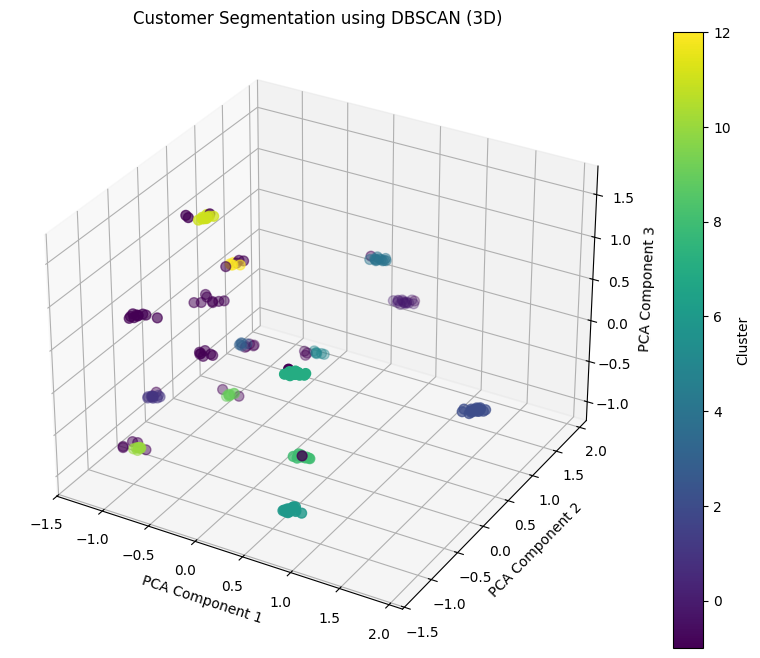

In [88]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

pca = PCA(n_components=3)
pca_result = pca.fit_transform(customer_data.drop(columns=['CustomerID', 'Cluster']))

customer_data['PCA1'] = pca_result[:, 0]
customer_data['PCA2'] = pca_result[:, 1]
customer_data['PCA3'] = pca_result[:, 2]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    customer_data['PCA1'],
    customer_data['PCA2'],
    customer_data['PCA3'],
    c=customer_data['Cluster'],
    cmap='viridis',
    s=50
)

plt.colorbar(scatter, ax=ax, label='Cluster')
ax.set_title('Customer Segmentation using DBSCAN (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.show()


This plot has a lot of overlapping clusters, making it inappropriate for classification. Thus, K-means is giving the best cluster separation.